# Feature aggregation

This part focuses on the **feature aggregation** approach to dimensionality reduction. It uses a grouping of original features and summarizes each group into one aggregated feature. We will first load the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1)
scaler = StandardScaler().set_output(transform="default")
data = scaler.fit_transform(data_original)
tissue_dict = {'floral': 'gold', 'leaf': 'chartreuse', 'root': 'gray', 'sdling': 'mediumseagreen', 'stem': 'darkgreen', 'veg': 'purple'}
species_dict = {'penn': 'orange', 'M82': 'blue'}

## Knowledge-based feature aggregation

We used gene sets from Gene Ontology (GO) already in the first notebook of this course. Here we will use them again to demonstrate knowledge-based feature aggregation, the first type of feature aggregation approaches. Each gene set represents a specific biological function. GO covers several thousands of functional terms, here we focus only on the most relevant high-level functions in plants as defined by GO slim, and specifically the subset which has annotations for tomato plants. By summarizing the gene expression values of each high-level function into a single value, the expression profile of a sample gets much more compact and can be visualized more easily, e.g. by a heatmap.

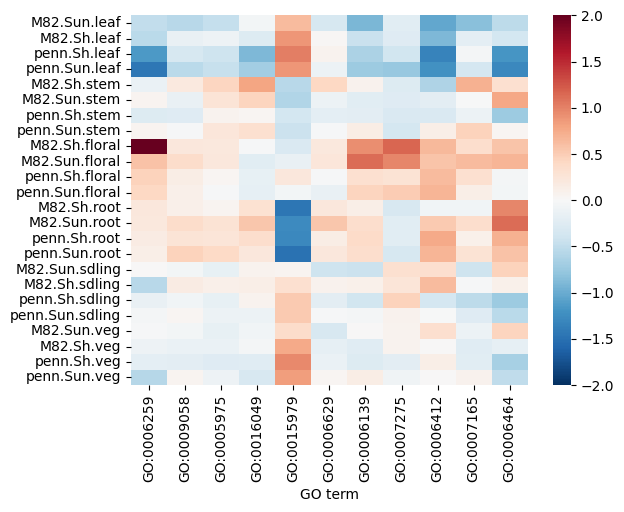

In [5]:
def extract_part(x, part, spl='.'):
    s = [elem.split(spl) for elem in x]
    return [elem[part] for elem in s]   
df = pd.DataFrame(data)
df.columns = extract_part(data_original.columns, part=0)
df.index = data_original.index
rd = pd.read_csv("../data/goslim_to_genes.txt", header=0, delimiter='\t')
def aggregate(i, f=np.mean):
    s = rd.iloc[i, 1].split(',')
    currdatraw = data[:, [df.columns.get_loc(col) for col in s if col in df.columns]]
    return np.apply_along_axis(f, 1, currdatraw)
newdat = np.array([aggregate(i) for i in range(len(rd))]).T
newdat_df = pd.DataFrame(newdat, index=df.index, columns=rd.iloc[:, 0])
anno_df_raw = pd.DataFrame({'species': [species_dict[extract_part([i], part=0)[0]] for i in df.index], 'tissue': [tissue_dict[extract_part([i], part=2)[0]] for i in df.index]})
to_order = anno_df_raw.apply(lambda x: f"{x['tissue']}.{x['species']}", axis=1)
s = to_order.sort_values().index
anno_df = anno_df_raw.loc[s, :]
newdat_df = newdat_df.iloc[s, :]
def create_heatmap(X, mybreaks=np.arange(-2, 2.01, 0.01)):
    cmap = LinearSegmentedColormap.from_list('RdBu', sns.color_palette("RdBu_r", n_colors=len(mybreaks)))
    sns.heatmap(X, cmap=cmap, vmin=mybreaks[0], vmax=mybreaks[-1])
create_heatmap(newdat_df)

## Data-driven feature aggregation